# Running a Model

## For Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Project_imageGen/project-image_generation

## For Own computer

In [1]:
!pwd

/home/jupyter/project-image_generation


In [ ]:
pip install pytorch-ignite

In [14]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torchvision

In [28]:
pip uninstall nvidia_cublas_cu11 --yes

Found existing installation: nvidia-cublas-cu11 11.10.3.66
Uninstalling nvidia-cublas-cu11-11.10.3.66:
  Successfully uninstalled nvidia-cublas-cu11-11.10.3.66
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Importing
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import display
import numpy as np
import torch

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import uuid

import ignite
from ignite.metrics import FID

from modules import UNet
from modules import UNet_2xUD
from modules import UNet_2xUD_halfchannels


seed = 449
random.seed(seed)
torch.manual_seed(seed)
num_images = 500
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [4]:
torch.cuda.is_available()

True

## Added code needed from CatDiffusion

In [5]:
def view_some_images(num_images, output_folder):
  to_tensor = transforms.ToTensor()
  for i in range(num_images):
    image = Image.open(os.path.join(output_folder, f"{i}.png"))
    image_tensor = to_tensor(image)
    plt.figure()
    plt.imshow(np.transpose(image_tensor, (1, 2, 0)))

In [6]:
def save_images(images, path, **kwargs):
    # grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = images.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [7]:
class Diffusion:
    # diffusion tools: noise schedule, forward process (noising), sampling images
    def __init__(self, noise_steps=1000, beta_0=1e-4, beta_T=0.02, img_size=32, device="cuda", schedule="cosine"):
        self.noise_steps = noise_steps
        self.beta_0 = beta_0
        self.beta_T = beta_T
        self.img_size = img_size
        self.device = device

        self.beta = self.noise_schedule(schedule).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.flag = 0
        self.fixed = None
    
    def noise_schedule(self, type):
        """
        Creates the noise schedule used by the diffusion class

        Parameters
        ----------
        type : {"linear", "cosine"}
            The type of schedule to be created.
        """

        if type == "linear":
            return torch.linspace(self.beta_0, self.beta_T, self.noise_steps)
        elif type == "cosine":
            # from https://openreview.net/forum?id=-NEXDKk8gZ and https://github.com/lucidrains/denoising-diffusion-pytorch/
            s = 0.008
            t = torch.linspace(0, self.noise_steps, steps=self.noise_steps+1)
            f = torch.cos(((t / self.noise_steps) + s) / (1 + s) * (np.pi / 2)) ** 2
            alphas_hat = f / f[0]
            betas = 1 - (alphas_hat[1:] / alphas_hat[:-1])
            return torch.clip(betas, 0, self.beta_T)
    
    def noise_images(self, x, t):
        """
        Noises image using the reparameterization trick to noise in a single step.

        Returns
        ----------
        Tensor
            Image noised to timestep t
        epsilon : Tensor
            Noise added to image
        """

        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None] #TODO why this dimension?
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, disable_bar=True, out=None, fixed=False):
        # n: number of images to sample
        # algorithm 2 from DDPM paper

        model.eval()
        with torch.no_grad():
            # generate random vector as starting point, or use fixed noise
            if (fixed == False):
                x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            else:
                if self.flag == 0:
                    self.fixed = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
                    self.flag = 1
                x = self.fixed
            # run through all steps to denoise image
            for i in tqdm(reversed(range(1, self.noise_steps)), disable=disable_bar):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                if i > 1:
                    # TODO: why are we adding noise for backwards process?
                    noise = torch.randn_like(x)
                else:
                    # don't add noise for the last step
                    noise = torch.zeros_like(x)

                # denoise image using algorithm 2 step 4
                x = 1 / torch.sqrt(alpha) * (x - ((1-alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

                # save in array if given
                if out is not None:
                    generated = (x.clamp(-1, 1) + 1) / 2
                    generated = (generated*255).type(torch.uint8)
                    generated = torchvision.utils.make_grid(generated).cpu().numpy()
                    out.append(generated)
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x*255).type(torch.uint8)
        return x

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Importing test dataset images (class cat)

In [9]:
pip install --upgrade torch torchvision

  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


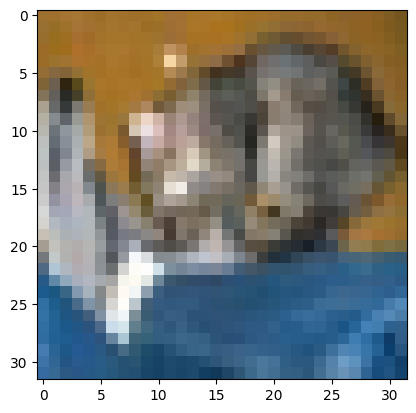

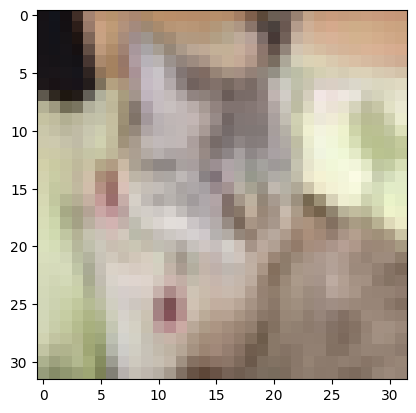

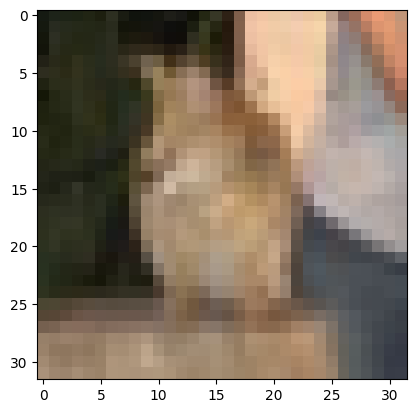

In [10]:
batch_size = 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
cat_idxs = np.where((np.array(testset.targets) == 3))[0]
catset = torch.utils.data.Subset(testset, cat_idxs)
cattestloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)


iterator = iter(cattestloader)
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))

images, _ = next(iter(iterator))
imshow(torchvision.utils.make_grid(images.squeeze()))


In [11]:
l = len(cattestloader)
print(l)

1000


### Save images from test dataset

In [12]:
import shutil

In [19]:
test_folder = "test_images"
output_folder = os.path.join("output/images1000_FID/", test_folder)
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

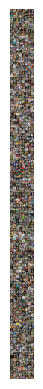

In [20]:
test_folder = "test_images"
output_folder = os.path.join("output/images1000_FID/", test_folder)
os.makedirs(output_folder, exist_ok=True)

img_grid_images = []
for i, (images, _) in enumerate(cattestloader):
  images = images.squeeze()
  if i<1000:
    images = images/2 + 0.5
    img_grid_images.append(images)
    image_path = os.path.join(output_folder, f"{i}.png")
    save_image(images, image_path)

img_grid = torchvision.utils.make_grid(img_grid_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [21]:
print(len([name for name in os.listdir(os.path.join("./output/images1000_FID/test_images"))]))

1000


## Saving data train dataset

Files already downloaded and verified


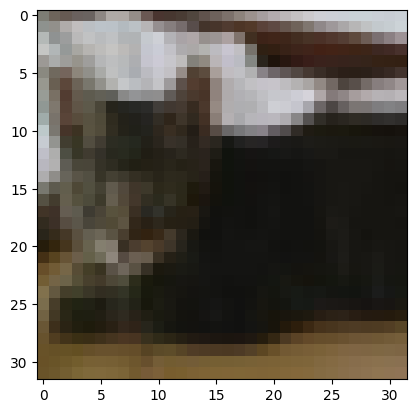

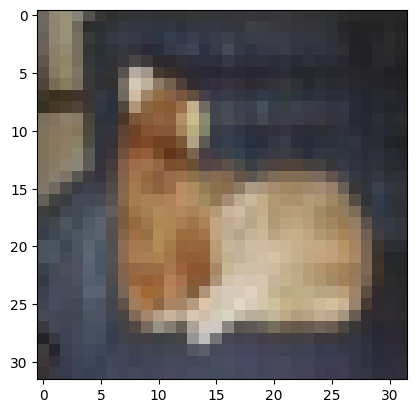

In [22]:
batch_size = 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
cat_idxs = np.where((np.array(testset.targets) == 3))[0]
catset = torch.utils.data.Subset(testset, cat_idxs)
cattrainloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)


iterator2 = iter(cattrainloader)
images, _ = next(iterator2)
imshow(torchvision.utils.make_grid(images))
images, _ = next(iterator2)
imshow(torchvision.utils.make_grid(images))

In [23]:
l = len(cattrainloader)
print(l)

5000


### Save images from train dataset

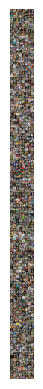

In [24]:
test_folder = "train_images"
output_folder = os.path.join("output/images1000_FID/", test_folder)
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

img_grid_images2 = []
for i, (images, _) in enumerate(cattrainloader):
  images = images.squeeze()
  if i<1000:
    images = images/2 + 0.5
    img_grid_images2.append(images)
    image_path = os.path.join(output_folder, f"{i}.png")
    save_image(images, image_path)

img_grid2 = torchvision.utils.make_grid(img_grid_images2)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [25]:
#print(os.listdir("./output"))
print(len([name for name in os.listdir(os.path.join("./output/images1000_FID/train_images"))]))

1000


In [26]:
pip install pytorch-fid

Note: you may need to restart the kernel to use updated packages.


In [31]:
!python -m pytorch_fid output/images1000_FID/train_images output/images1000_FID/test_images
#should be ~0

  0%|                                                    | 0/20 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/opt/conda/lib/python3.7/site-packages/pytorch_fid/fid_score.py", line 317, in main
    num_workers)
  File "/opt/conda/lib/python3.7/site-packages/pytorch_fid/fid_score.py", line 260, in calculate_fid_given_paths
    dims, device, num_workers)
  File "/opt/conda/lib/python3.7/site-packages/pytorch_fid/fid_score.py", line 244, in compute_statistics_of_path
    dims, device, num_workers)
  File "/opt/conda/lib/python3.7/site-packages/pytorch_fid/fid_score.py", line 228, in calculate_activation_statistics
    act = get_activations(files, model, batc

# FID for 2xUD_halfchannels

In [ ]:
import types
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-3e4lr-UNet_2xUD_halfchannels"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet_2xUD_halfchannels"

In [ ]:
# original structure


path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet().to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD().to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)


# structure reduced to 2x up down blocks
# args.run_name = "1e4lr"
# path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
# model = UNet_2xUD().to("cuda")

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
diffusion = Diffusion(img_size=args.image_size, device=args.device)



### Saving Gen images to folder "halfChannel_images"

In [ ]:

args.folder_name = "halfChannel_images"
model.load_state_dict(torch.load(path))
diffusion = Diffusion(img_size=args.image_size, device="cuda")
image_batches = []
for i in range(5):
  iarr = []
  image_batches.append(diffusion.sample(model, n=100, disable_bar=False, out=iarr))
images_batches = tuple(image_batches)
sampled_images = torch.cat(image_batches, dim=0)
img_grid = torchvision.utils.make_grid(sampled_images)

ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()


In [ ]:

# Create the output folder if it doesn't exist
output_folder = os.path.join("output/images_FID/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      #print(image)
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()


In [ ]:
view_some_images(5, "output/images_FID/halfChannel_images")

In [ ]:
print(len([name for name in os.listdir(os.path.join("output/images_FID/", args.folder_name))]))

### Doing the FID

In [ ]:
pip install pytorch-fid

In [ ]:
!python -m pytorch_fid output/images_FID/halfChannel_images output/images_FID/test_images

# FID for UNet_2xUD

In [ ]:
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-3e4lr-UNet_2xUD"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet_2xUD"

In [ ]:
path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [ ]:
diffusion = Diffusion(img_size=args.image_size, device="cuda")
image_batches = []
for i in range(5):
  iarr = []
  image_batches.append(diffusion.sample(model, n=100, disable_bar=False, out=iarr))
images_batches = tuple(image_batches)
sampled_images = torch.cat(image_batches, dim=0)


### Adding generated Images to folder 2xUD_Images

In [ ]:
args.folder_name = "2xUD_Images"
# Create the output folder if it doesn't exist
output_folder = os.path.join("output/images_FID/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [ ]:
view_some_images(5, "output/images_FID/2xUD_Images")

## FID for 2xUD

In [ ]:
!python -m pytorch_fid output/images_FID/2xUD_Images output/images_FID/test_images

# FID for 3xBlocks

In [ ]:
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-3e4lr-3xblocks"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet"

In [ ]:
path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [ ]:
diffusion = Diffusion(img_size=args.image_size, device="cuda")
image_batches = []
for i in range(5):
  iarr = []
  image_batches.append(diffusion.sample(model, n=100, disable_bar=False, out=iarr))
images_batches = tuple(image_batches)
sampled_images = torch.cat(image_batches, dim=0)

### Adding generated Images to folder 3xblocks_Images

In [ ]:
args.folder_name = "3xblocks_Images"
# Create the output folder if it doesn't exist
output_folder = os.path.join("output/images_FID/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [ ]:
view_some_images(5, "output/images_FID/3xblocks_Images")

## FID for 3xblocks

In [ ]:
!python -m pytorch_fid output/images_FID/3xblocks_Images output/images_FID/test_images

# FID for Cosine test 1024 ep

In [ ]:
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-UNet-cosine-test"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet"

In [ ]:
torch.cuda.is_available()

In [ ]:
path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [ ]:
diffusion = Diffusion(img_size=args.image_size, device="cuda", schedule="cosine")
image_batches = []
for i in range(5):
  iarr = []
  image_batches.append(diffusion.sample(model, n=100, disable_bar=False, out=iarr))
images_batches = tuple(image_batches)
sampled_images = torch.cat(image_batches, dim=0)

### Adding generated Images to folder Cosine_images

In [ ]:
args.folder_name = "Cosine_images"
# Create the output folder if it doesn't exist
output_folder = os.path.join("output/images_FID/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [ ]:
view_some_images(5, "output/images_FID/Cosine_images")

In [ ]:
print(len([name for name in os.listdir(os.path.join("output/images_FID/", args.folder_name))]))

## FID for Cosine

In [ ]:
!python -m pytorch_fid output/images_FID/Cosine_images output/images_FID/test_images

## Function definitions to make the above easier

In [ ]:
def save_test_images(num_images, folder_name):
  batch_size = 1
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  cat_idxs = np.where((np.array(testset.targets) == 3))[0]
  catset = torch.utils.data.Subset(testset, cat_idxs)
  catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)



  images, _ = next(iter(catloader))
  imshow(torchvision.utils.make_grid(images))
  test_folder = folder_name
  output_folder = os.path.join("output/", test_folder)
  os.makedirs(output_folder, exist_ok=True)

  img_grid_images = []
  for i, (images, _) in enumerate(catloader):
    if i<num_images:
      images = images/2 + 0.5
      img_grid_images.append(images[0])
      image_path = os.path.join(output_folder, f"{i}.png")
      save_image(images[0], image_path)

  img_grid = torchvision.utils.make_grid(img_grid_images)
  ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
  plt.figure()
  plt.axis("off")
  plt.imshow(ndarr)
  plt.show()

In [ ]:
def save_images_model(num_images, args, folder_name):
  path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
  if (args.model == "UNet"):
      model = UNet(device=args.device).to(args.device)
  elif (args.model == "UNet_2xUD"):
      model = UNet_2xUD(device=args.device).to(args.device)
  elif (args.model == "UNet_2xUD_halfchannels"):
          model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

  if torch.cuda.is_available():
    model.load_state_dict(torch.load(path))
  else:
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

  diffusion = Diffusion(img_size=args.image_size, device="cuda")
  sampled_images = diffusion.sample(model, n=num_images, disable_bar=False)

  args.folder_name = folder_name
  # Create the output folder if it doesn't exist
  output_folder = os.path.join("output/", args.folder_name)
  os.makedirs(output_folder, exist_ok=True)

  # Save each image individually
  for i, image in enumerate(sampled_images):
      if i<num_images:
        image_path = os.path.join(output_folder, f"{i}.png")
        save_images(image, image_path)
      """
      if i<5:
        plt.figure()
        plt.imshow(image.permute(1,2,0).to('cpu').numpy())
      """

  # Display the image grid
  img_grid = torchvision.utils.make_grid(sampled_images)
  ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
  plt.figure()
  plt.axis("off")
  plt.imshow(ndarr)
  plt.show()

# Trying out the GAN

In [ ]:
nc = 3      # number of channels in training image
nz = 128    # latent vector size

# size of feature maps in generator and discriminator
ngf = 64
ndf = 64

num_epochs = 1024
lr = 0.0002
beta1 = 0.5
ngpu = 1
smoothed = True
noised = True

In [ ]:
def imshow(img, title=""):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
def save_images(images, path, **kwargs):
    # grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = images.permute(1, 2, 0).to('cpu').numpy()
    #print(ndarr.shape)
    im = Image.fromarray(ndarr)
    im.save(path)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.relu = nn.ReLU(True)
        self.cvt1 = nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        
        self.cvt2 = nn.ConvTranspose2d(ngf * 4, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)

        self.cvt3 = nn.ConvTranspose2d(ngf * 4, ngf, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)

        self.cvt4 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.cvt1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.cvt2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.cvt3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.cvt4(x)
        x = self.tanh(x)
        return x

# Doing GAN 1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt

In [ ]:

path = "models/CatGAN/1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(500, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path))

loaded.eval()
out = loaded(noise).cpu()
out= out.detach()


In [ ]:

img_folder = "1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G_images/"
#print(out)
#print(out.shape)
output_folder = os.path.join("output/images_FID/", img_folder)
#shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)


# Save each image individually
for i, image in enumerate(out):
  image_path = os.path.join(output_folder, f"{i}.png")
  toPIL = transforms.ToPILImage()
  #ndarr = ((image /2 +0.5)*255).permute(1,2,0).numpy()
  #print(ndarr)
  newPIL = toPIL(image/2 + 0.5)
  #newPIL.show()
  newPIL.save(image_path)
  #im = Image.fromarray(ndarr)
  #plt.imshow((image/2 + 0.5).permute(1,2,0))
  #im.save(image_path)

# Display the image grid

img_grid = torchvision.utils.make_grid(out)
imshow(img_grid)


In [ ]:
view_some_images(5, "output/images_FID/1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G_images")

In [ ]:
print(len([name for name in os.listdir(os.path.join("./output/images_FID/", img_folder))]))

In [ ]:
pip install pytorch-fid

## FID for smoothed GAN

In [ ]:
!python -m pytorch_fid output/images_FID/1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G_images output/images_FID/test_images

# Doing GAN 1024ep_64nf_128nz_default-D_default-G.pt

In [ ]:
# Other generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 4 x 4``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 8 x 8``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 16 x 16``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 32 x 32``
        )

    def forward(self, x):
        return self.net(x)

In [ ]:

path = "models/CatGAN/1024ep_64nf_128nz_default-D_default-G.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(500, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path, map_location=device))

loaded.eval()
out = loaded(noise).cpu()
out= out.detach()


In [ ]:

img_folder = "1024ep_64nf_128nz_default-D_default-G_images/"
#print(out)
#print(out.shape)
output_folder = os.path.join("output/images_FID/", img_folder)
#shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)


# Save each image individually
for i, image in enumerate(out):
  image_path = os.path.join(output_folder, f"{i}.png")
  toPIL = transforms.ToPILImage()
  #ndarr = ((image /2 +0.5)*255).permute(1,2,0).numpy()
  #print(ndarr)
  newPIL = toPIL(image/2 + 0.5)
  #newPIL.show()
  newPIL.save(image_path)
  #im = Image.fromarray(ndarr)
  #plt.imshow((image/2 + 0.5).permute(1,2,0))
  #im.save(image_path)

# Display the image grid

img_grid = torchvision.utils.make_grid(out)
imshow(img_grid)


In [ ]:
view_some_images(5, "output/images_FID/1024ep_64nf_128nz_default-D_default-G_images")

In [ ]:
print(len([name for name in os.listdir(os.path.join("./output/images_FID/", img_folder))]))

## FID for default gan 1024 ep

In [ ]:
!python -m pytorch_fid output/images_FID/1024ep_64nf_128nz_default-D_default-G_images output/images_FID/test_images

# Doing GAN 512ep_64nf_128nz_default-D_default-G.pt

In [ ]:

path = "models/CatGAN/512ep_64nf_128nz_default-D_default-G.pt"
gen = torch.Generator(device=device)
gen.seed()
noise = torch.randn(500, nz, 1, 1, device=device, generator=gen)

loaded = Generator(ngpu).to(device)
loaded.load_state_dict(torch.load(path, map_location=device))

loaded.eval()
out = loaded(noise).cpu()
out= out.detach()


In [ ]:

img_folder = "512ep_64nf_128nz_default-D_default-G_images/"
#print(out)
#print(out.shape)
output_folder = os.path.join("output/images_FID/", img_folder)
#shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)


# Save each image individually
for i, image in enumerate(out):
  image_path = os.path.join(output_folder, f"{i}.png")
  toPIL = transforms.ToPILImage()
  #ndarr = ((image /2 +0.5)*255).permute(1,2,0).numpy()
  #print(ndarr)
  newPIL = toPIL(image/2 + 0.5)
  #newPIL.show()
  newPIL.save(image_path)
  #im = Image.fromarray(ndarr)
  #plt.imshow((image/2 + 0.5).permute(1,2,0))
  #im.save(image_path)

# Display the image grid

img_grid = torchvision.utils.make_grid(out)
imshow(img_grid)


In [ ]:
view_some_images(5, "output/images_FID/512ep_64nf_128nz_default-D_default-G_images")

In [ ]:
print(len([name for name in os.listdir(os.path.join("./output/images_FID/", img_folder))]))

## FID for default gan 512 epochs

In [ ]:
!python -m pytorch_fid output/images_FID/512ep_64nf_128nz_default-D_default-G_images output/images_FID/test_images